In [112]:
import numpy as np

import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_colwidth', 100)

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")
sns.set_palette("bright")

import sqlite3
from datetime import datetime as dt
import re
import unicodedata

from nlp_utils import get_english_stopwords
from nlp_utils import CONTRACTION_MAP, CONVERSATIONAL_ABBREVIATION_MAP
from nlp_utils import print_completion_message
from nlp_utils import plot_label_frequencies, plot_document_frequencies, average_token_length

from classification_utils import plot_validation_confusion_matrices

from nn_utils import plot_history

import nltk
from nltk import pos_tag as pos_tag_words 
from nltk import pos_tag_sents as pos_tag_sentences 
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_sample_weight

import tensorflow as tf
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import TextVectorization, Input, Embedding, Dense , Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import Constant
from keras.utils import plot_model

FRACTION = 0.15


# A. *Business Context*


*FP1 Strategies* is a campaign consulting and advertising firm dedicated to helping Republican candidates achieve political success. However, the divide between Liberals and Conservatives has been growing at an alarming rate these last few decades, and this has dramatically affected the American political landscape. Within the Republican and Democratic parties, the number of memebers with a highly negative view of the opposing party has more than doubled since 1994, while the ideological overlap between the two parties has diminished greatly.[^1]

This team at *FP1 Strategies* sees the in **partisanship** as an oppurtunity. They believe that, because of the factors discussed above, candidates who attempt to placate both sides, trying to be pallatable to everyone, are destined to fail. Those who are willing to take a more direct and authentic approach, who can resonate with the Conservative demographic, can achieve great success. However, the company needs a better way of identifying and reaching out to the Conservative population. Traditional canvassing is slow, cumbersome, and inefficient. In order to improve this, the team at *FP1 Strategies* has come up with an idea called *remote canvassing*. They want to use machine learning to identify a person's ideological preference (i.e. if they are Conservative/Liberal) solely based on their past activity on social media. If the person is determined to be sufficiently conservative, it is assumed they are likely to vote Republican, and the team would reach out to them online, that is, canvass remotely. This is just half the battle, because they also need to know specifically which issues to address when canvassing for potential supporters. Thus, the requirement of being identified as "sufficiently conservative" has to be done with respect to one of the major societal issues that a political candidate can address and garner support for.

*The company wishes to see a demonstration showing that remote canvassing is practically achievable. It should utilize data form social media to answer the following questions:*
> * **Can we use machine learning to accurately determine whether someone takes a Conservative/Liberal stance on an issue?**

# B. *Data Understanding*

## B.1 - Background Information


Collecting data was an involved process. The Conservative and Liberal ideologies are vast, and they play a part in almost every domain of modern life in the United States. Among the numerous issues that parallell the Conservative/Liberal divide, a set of $5$ were chosen. One has to make sure they are polarizing enough to provide meaningful data, yet not too complex or multi-faceted that data collection becomes difult. These issues were:

* Abortion
* Immigration
* Healthcare
* Gun Control
* Climate Change

Distilling Conservative/Liberal beliefs into a set of cultural issues was necessary because one's stance in regards to each these issues can indeed be quantified with data. The idea is that a person can be identified as Conservative/Liberal by considering the their stance on these contentious topics.

For each of the issues listed above, it is important to define what is meant by a "liberal" viewpoint and a "conservative" viewpoint. The generally accepted definitions of these are summarized in the following sections.[^2]

##### *Abortion*

* __Liberal:__ A pregnant woman has a right to abort the fetus because she has autonomy over her body.

* __Conservative:__ A fetus is a human being deserving of legal protection, separate from the will of the mother.

##### *Immigration*

* __Liberal:__ Illegal immigrants deserve rights such as financial aid for college tuition and visas for immediate family members back home.

* __Conservative:__ Government should enforce immigration laws. Those who break the law by entering the United States illegally should not have the same rights as those who obey the law by entering the country legally.

##### *Healthcare*

* __Liberal:__ Support universal health care subsidized by the government. Free healthcare is a basic right that everyone is entitled to.

* __Conservative:__ Free healthcare provided by the government (socialized medicine) means that everyone will get the same poor-quality healthcare. The rich will continue to pay for superior healthcare, while the rest of us receive inadequate healthcare from the government.

##### *Gun Control*

* __Liberal:__ The Second Amendment gives no individual the right to own a gun, but allows the state to keep a militia (National Guard/Armed Forces). Guns are too dangerous.

* __Conservative:__ The Second Amendment gives the individual the right to keep and bear arms. Gun control laws do not thwart criminals. You have a right to defend yourself against criminals. More guns mean less crime.

##### *Climate Change*

* __Liberal:__ Industrial growth harms the environment. Therefore, the U.S. should enact laws to significantly
reduce this, even if it comes at the cost of economic growth.

* __Conservative:__ Changes in global temperatures are natural over long periods of time. Science has not definitively proven humans guilty of permanently changing the Earth's climate.

## B.2 - Data Collection


The data is comprised entirely of posts and comments scraped from the Reddit API. Reddit is a massive collection of forums in which various communities (called Subreddits) post content, discuss ideas, and share news. Reddit was an ideal source of data because there are several communities specifically dedicated to discussing one or more of the above mentioned issues, and which represent both the Liberal and Conservative sides of the debate. Therefore, data was labeled simply according to the Subreddit it belonged to. The process began by manually searching Reddit and curating a group of Subreddits whose community fell under one of the $5$ controversial topics discussed above.

In addition, subreddits pertaining to ideological preference (Conservative/Liberal) and partisanship (Republican/Democrat) were identified and scraped.

It is important to note that two of the Subreddits were used to find posts pertaining to more than one issue. Namely, the `r/AskTrumpSupporters` and `r/Political_Revolution` Subreddits. This could be done because their posts were tagged by sub-topic. (In Reddit language, this is referred to as post *flair*).

The complete list of curated Subredits is shown below:

- **`r/progun`** [Issue(s): **Gun Control** | Stance: **Conservative**]
- **`r/Firearms`** [Issue(s): **Gun Control** | Stance: **Conservative**]
- **`r/gunpolitics`** [Issue(s): **Gun Control** | Stance: **Conservative**]
- **`r/prolife`** [Issue(s): **Abortion** | Stance: **Conservative**]
- **`r/AskTrumpSupporters`** [Issue(s): **Climate Change**, **Immigration**, **Healthcare** | Stance: **Conservative**]
- **`r/climateskeptics`** [Issue(s): **Climate Change** | Stance: **Conservative**]
- **`r/Conservative`** [Issue(s): **Ideology** | Stance: **Conservative**]
- **`r/ConservativesOnly`** [Issue(s): **Ideology** | Stance: **Conservative**]
- **`r/Republican`** [Issue(s): **Partisanship** | Stance: **Conservative**]
- **`r/GunsAreCool`** [Issue(s): **Gun Control** | Stance: **Liberal**]
- **`r/guncontrol`** [Issue(s): **Gun Control** | Stance: **Liberal**]
- **`r/prochoice`** [Issue(s): **Abortion** | Stance: **Liberal**]
- **`r/climate`** [Issue(s): **Climate Change** | Stance: **Liberal**]
- **`r/ClimateOffensive`** [Issue(s): **Climate Change** | Stance: **Liberal**]
- **`r/JoeBiden`** [Issue(s): **Immigration** | Stance: **Liberal**]
- **`r/MedicareForAll`** [Issue(s): **Healthcare** | Stance: **Liberal**]
- **`r/Political_Revolution`** [Issue(s): **Immigration**, **Healthcare** | Stance: **Liberal**]
- **`r/Liberal`** [Issue(s): **Ideology** | Stance: **Liberal**]
- **`r/progressive`** [Issue(s): **Ideology** | Stance: **Liberal**]
- **`r/democrats`** [Issue(s): **Partisanship** | Stance: **Liberal**]


All of the Subreddits above contain anywhere from thousands to tens of thousands of posts. To make the selection process easier, the most popular posts from each Subreddit were collected, along with their comment threads.


Data extracted from the from the Reddit API was stored in the database file: `data/reddit_data.db`. The schema for this database is shown below:

<center><img src="images/database-schema.png" width='600'></center>

## B.3 - Data Description

#### Subreddits

> *The `subreddits` table contains the following columns:*
> * __id__ *[int] - unique identifier of the (name, issue) pair*
> * __name__ *[str] - name of subreddit*
> * __suscribers__ *[int] - number of users subscribed to subreddit*
> * __issue__ *[str] - subreddit topic (`abortion` | `immigration`|`healthcare` | `gun_control` | `climate` | `party` | `ideology`)*
> * __stance__ *[str] - overall stance taken by the subreddit's community (`conservative` | `liberal`)*


#### Posts

> *The `posts` table contains the following columns:*
> * __id__ *[str] - unique identifier of the post*
> * __subreddit_id__ *[int] - unique identifier of the parent subreddit*
> * __author_id__ *[int] - unique identifier of the posts's author*
> * __title__ *[int] - title of the post*
> * __score__ *[str] - number of upvotes the post has recieved in its lifetime*
> * __upvote_ratio__ *[float] - ratio of upvotes to downvotes*
> * __date__ *[int] - date the post was created (Unix time stamp)*

#### Comments

> *The `comments` table contains the following columns:*
> * __id__ *[str] - unique identifier of the comment*
> * __subreddit_id__ *[int] - unique identifier of subreddit containing the parent post*
> * __post_id__ *[int] - unique identifier of parent post*
> * __author_id__ *[int] - unique identifier of the posts's author*
> * __body__ *[int] - the comment's main body of text*
> * __score__ *[str] - number of upvotes the comment has recieved in its lifetime*
> * __date__ *[int] - date the comment was created (Unix time stamp)*

#### Users

> *The `users` table contains the following columns:*
> * __id__ *[str] - unique identifier of a Reddit user identified in the `posts`/`comments` table*
> * __subreddit_id__ *[int] - unique identifier of subreddit in which the above Reddit user created a post/comment*


## B.4 - Importing the Dataset

> The `subreddits` and `comments` tables from `data/reddit_data.db` were loaded into memory, and a corpus, made up of individual comments, was created by merging the two `DataFrame` objects. 

In [113]:
conn = sqlite3.connect('data/reddit_data.db')

### *B.4.1 - Importing the `subreddits` Table*

In [114]:
query = """--sql
         SELECT id, name, issue, stance 
         FROM subreddits
         """
subreddit_df = pd.read_sql(query, conn, index_col="id")

In [115]:
subreddit_df

,name,issue,stance
id,,,
1,r/progun,gun_control,conservative
2,r/Firearms,gun_control,conservative
3,r/gunpolitics,gun_control,conservative
4,r/prolife,abortion,conservative
5,r/AskTrumpSupporters,climate,conservative
6,r/climateskeptics,climate,conservative
7,r/AskTrumpSupporters,immigration,conservative
8,r/ImmigrationReform,immigration,conservative
9,r/AskTrumpSupporters,healthcare,conservative


### *B.4.2 - Importing the `comments` Table*

In [116]:
query = """--sql
         SELECT id, subreddit_id, body, score, date 
         FROM comments
         """
comment_df = pd.read_sql(query, conn)

In [117]:
comment_df.head()

,id,subreddit_id,body,score,date
0,fqwzlb2,1,Please keep your discussion civil per Rule #3. Comments advocating the killing of cops or others...,1,1589722149
1,fqw2qz2,1,"Plainclothes, no knock in the middle of the night, wrong house and killed an innocent woman. Pre...",3418,1589691227
2,fqw21ew,1,I hope this guy sues and the officers involved end up with charges as they murdered his girlfriend.,1328,1589690687
3,fqw5032,1,This is so messed up. Is there anywhere we can donate to his defense?\n\nGOOOD NEWS: found the g...,1075,1589693022
4,fqw47i6,1,No knock raids should be illegal. This isn't the first time this has happened. He should be a fr...,726,1589692378


### *B.4.3 - Creating the Corpus*

In [118]:
corpus = comment_df.join(subreddit_df, on="subreddit_id").rename(columns={"id":"comment_id", "name": "subreddit_name", "body": "text"}).drop(columns=["subreddit_id", "subreddit_name"])

In [119]:
dropped_issues_index = corpus.loc[corpus.issue.str.fullmatch(r"ideology|party")].index
corpus.drop(dropped_issues_index, inplace=True)
corpus[["issue", "stance"]] = corpus[["issue", "stance"]].applymap(str.upper)


In [120]:
corpus.head()

,comment_id,text,score,date,issue,stance
0,fqwzlb2,Please keep your discussion civil per Rule #3. Comments advocating the killing of cops or others...,1,1589722149,GUN_CONTROL,CONSERVATIVE
1,fqw2qz2,"Plainclothes, no knock in the middle of the night, wrong house and killed an innocent woman. Pre...",3418,1589691227,GUN_CONTROL,CONSERVATIVE
2,fqw21ew,I hope this guy sues and the officers involved end up with charges as they murdered his girlfriend.,1328,1589690687,GUN_CONTROL,CONSERVATIVE
3,fqw5032,This is so messed up. Is there anywhere we can donate to his defense?\n\nGOOOD NEWS: found the g...,1075,1589693022,GUN_CONTROL,CONSERVATIVE
4,fqw47i6,No knock raids should be illegal. This isn't the first time this has happened. He should be a fr...,726,1589692378,GUN_CONTROL,CONSERVATIVE


In [121]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51927 entries, 0 to 64749
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  51927 non-null  object
 1   text        51927 non-null  object
 2   score       51927 non-null  int64 
 3   date        51927 non-null  int64 
 4   issue       51927 non-null  object
 5   stance      51927 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.8+ MB


In [122]:
conn.close()

# 
---

In [123]:
corpus = corpus.sample(frac=FRACTION)
corpus 

,comment_id,text,score,date,issue,stance
1213,foh9kyy,"> “Reddit is neutral and doesn't hate people just for holding a different worldview...""\n\nHuh? ...",6,1587762301,ABORTION,CONSERVATIVE
61032,ilolfgc,I was 11. I was very small and sheltered and raised by very religious parents. I would be dead h...,16,1661394778,ABORTION,LIBERAL
38292,ijbi2zl,One of the saddest things about this story is that when Lina’s stomach began to grow her mother ...,246,1659885259,ABORTION,LIBERAL
37564,igmuza4,"This is 2022. Welcome to Nazi America.\n\nHitler: At last, my plan for a Thousand-Year Reich is ...",8,1658147421,ABORTION,LIBERAL
15101,givxo3h,The consensus among [scientists](https://people.uwec.edu/jamelsem/papers/CC_Literature_Web_Share...,14,1610377044,CLIMATE,LIBERAL
...,...,...,...,...,...,...
29993,iec1ivj,"""No luke, I will adopt your baby"" -Darth Vader or somethin idk",26,1656605510,ABORTION,CONSERVATIVE
13021,il62m4v,I saw a summary of conservatives (Or at least American conservatives) in that while they love te...,72,1661067846,CLIMATE,LIBERAL
48860,gtnr2sf,Talk about space camp,1,1617775145,IMMIGRATION,LIBERAL
60821,ilne3l3,Racism drives both sides of the argument to make sure:\n\n1. White men have access to guns\n2. T...,2,1661376530,GUN_CONTROL,LIBERAL


#
---

# C. *Data Preparation*

## C.1 - Cleaning the Corpus

### *C.1.1 - Removing Duplicate Comments*

We can see that `corpus` has entries with duplicate values for `comment_id`, which means these entries contain duplicate comments. These duplicates must be resolved.

In [124]:
corpus["comment_id"].is_unique

False

In [125]:
corpus = corpus.drop_duplicates("comment_id").set_index("comment_id")

In [126]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7613 entries, foh9kyy to ioclxpp
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   score   7613 non-null   int64 
 2   date    7613 non-null   int64 
 3   issue   7613 non-null   object
 4   stance  7613 non-null   object
dtypes: int64(2), object(3)
memory usage: 356.9+ KB


### *C.1.2 - Converting Dates to Standard ISO Format*

In [127]:
unix_to_iso_format = lambda unix_dt: dt.isoformat(dt.utcfromtimestamp(unix_dt)).split(sep='T')[0]

In [128]:
corpus["date"] = corpus["date"].apply(unix_to_iso_format)

In [129]:
corpus.head()

,text,score,date,issue,stance
comment_id,,,,,
foh9kyy,"> “Reddit is neutral and doesn't hate people just for holding a different worldview...""\n\nHuh? ...",6,2020-04-24,ABORTION,CONSERVATIVE
ilolfgc,I was 11. I was very small and sheltered and raised by very religious parents. I would be dead h...,16,2022-08-25,ABORTION,LIBERAL
ijbi2zl,One of the saddest things about this story is that when Lina’s stomach began to grow her mother ...,246,2022-08-07,ABORTION,LIBERAL
igmuza4,"This is 2022. Welcome to Nazi America.\n\nHitler: At last, my plan for a Thousand-Year Reich is ...",8,2022-07-18,ABORTION,LIBERAL
givxo3h,The consensus among [scientists](https://people.uwec.edu/jamelsem/papers/CC_Literature_Web_Share...,14,2021-01-11,CLIMATE,LIBERAL


In [130]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7613 entries, foh9kyy to ioclxpp
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   score   7613 non-null   int64 
 2   date    7613 non-null   object
 3   issue   7613 non-null   object
 4   stance  7613 non-null   object
dtypes: int64(1), object(4)
memory usage: 356.9+ KB


### *C.1.3 - Dropping [Deleted/Removed] Comments*

Entries whose `text` column contains one of the following strings:

> *`[deleted]` / `[removed]`* 

indicate the comment no longer exists, and must be dropped.

In [131]:
deleted_comments_index = corpus.loc[corpus.text.str.fullmatch(r"\[deleted\]|\[removed\]")].index
corpus.drop(deleted_comments_index, inplace=True)

In [132]:
all(corpus.text.str.fullmatch(r"\[deleted\]|\[removed\]"))

False

### *C.1.4 - Dropping Automatically Generated Comments*

Bot-generated comments are irrelevant and should be dropped. They are easily identified because they contain the sentence: 
> *`*I am a bot, and this action was performed automatically.`* 

In [133]:
bot_generated_comments_index = corpus.loc[corpus.text.str.contains(r"\*I am a bot, and this action was performed automatically.")].index
corpus.drop(bot_generated_comments_index, inplace=True)

In [134]:
all(corpus.text.str.contains(r"\*I am a bot, and this action was performed automatically."))

False

In [135]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7239 entries, foh9kyy to ioclxpp
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7239 non-null   object
 1   score   7239 non-null   int64 
 2   date    7239 non-null   object
 3   issue   7239 non-null   object
 4   stance  7239 non-null   object
dtypes: int64(1), object(4)
memory usage: 339.3+ KB


### *C.1.5 - Dropping Comments with More Downvotes than Upvotes*

In [136]:
bad_score_index = corpus.loc[corpus["score"] < 0].index
corpus.drop(index=bad_score_index, columns="score", inplace=True)

In [137]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6773 entries, foh9kyy to ioclxpp
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6773 non-null   object
 1   date    6773 non-null   object
 2   issue   6773 non-null   object
 3   stance  6773 non-null   object
dtypes: object(4)
memory usage: 264.6+ KB


## C.2 - Text Normalization

### *C.2.1 - Steps Involved in Text Normalization*

> The functions created below were sequentially applied to normalize the corpus.

##### *C.2.1.1 - Removing Quoted Sections*

When the author of a comment quotes some other person, it is always prefaced with a `>` symbol:
 
> *`> When are people on the left going to realize Trump doesn't like taking things of people especially his voters.`*
>
> *`You mean the guy who said "take the guns" doesn't like taking things? The guy proposing [massive cuts](https://www.vox.com/policy-and-politics/2018/2/12/16996832/trump-budget-2019-release-explained) to huge swaths of government programs including Social Security and Medicare doesn't like taking anything away from his voters?`*

Most comments were either quoting a conflicting point of view or quoting some saying from the past, which just adds noise to the data point and makes it less representative of its labels. Therefore, comments will be stripped of all quotes.

In [138]:
@print_completion_message(start_msg="Removing quoted sections")
def strip_quoted_sections(corpus, *, document_col):
    special_character_regex = r"^>.*(\n>)?$"
    special_character_pattern = re.compile(special_character_regex)
    def _strip_quoted_sections(text):
        return special_character_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_quoted_sections)

##### *C.2.1.2- Replacing Accented Characters*

In [139]:
@print_completion_message(start_msg="Stripping accents")
def strip_accents(corpus, *, document_col):
    def _strip_accents(text): 
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    corpus[document_col] = corpus[document_col].apply(_strip_accents)

##### *C.2.1.3 - Removing Newline Characters*

In [140]:
@print_completion_message(start_msg="Stripping newline characters")
def strip_newline_characters(corpus, *, document_col):
    newline_character_regex = r"\n+"  
    newline_character_pattern = re.compile(newline_character_regex)    
    def _strip_newline_characters(text):
        return newline_character_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_newline_characters)

##### *C.2.1.4 - Removing Web Addresses*

In [141]:
@print_completion_message(start_msg="Stripping web addresses")
def strip_web_addresses(corpus, *, document_col):
    web_address_regex = r"(https?\:\/\/\S*)|(w{3}\.\S+\.(com|org|gov|edu)\S*)|(\S*\.(com|org|gov|edu))"
    web_address_pattern = re.compile(web_address_regex, flags=re.IGNORECASE)
    def _strip_web_addresses(text):
        return web_address_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_web_addresses)


##### *C.2.1.5 - Removing HTML Entities*

In [142]:
@print_completion_message(start_msg="Stripping HTML entities")
def strip_html_entities(corpus, *, document_col):
    html_entity_regex = r"(&\S+;)+"
    html_entity_pattern = re.compile(html_entity_regex)
    def _strip_html_entities(text):
        return html_entity_pattern.sub(' ', text)
    corpus[document_col] = corpus[document_col].apply(_strip_html_entities)

##### *C.2.1.6 - Expanding Contractions*

In [143]:
@print_completion_message(start_msg="Expanding contractions")
def expand_contractions(corpus, *, document_col, contraction_mapping=CONTRACTION_MAP):
    SKIP_CONTRACTIONS = ["'cause", "she'd", "she'll", "he'll", "it's", "we'd", "we'll", "we're"]
    contraction_map_items = CONTRACTION_MAP.copy().items()
    for contraction, expanded_contraction in contraction_map_items:
        if contraction not in SKIP_CONTRACTIONS:
            CONTRACTION_MAP.update({contraction.replace('\'', ''): expanded_contraction})
    def _expand_contractions(text):
        def expand_match(contraction):
            match = contraction.group(0)           
            expanded_match = contraction_mapping[match.lower()] 
            if match[0].isupper():
                expanded_match = expanded_match[0].upper() + expanded_match[1:] 
            return expanded_match
        contractions_regex = "(" + '|'.join('\\b' + contraction + "\\b" for contraction in sorted(contraction_mapping.keys(), key=lambda x: len(x))) + ")"
        contractions_pattern = re.compile(contractions_regex)
        expanded_text = contractions_pattern.sub(expand_match, text)
        if contractions_pattern.search(expanded_text) is None:
            return expanded_text
        return contractions_pattern.sub(expand_match, expanded_text)
    corpus[document_col] = corpus[document_col].apply(_expand_contractions)

##### *C.2.1.7 - Expanding Abbreviated Words and Phrases*

In [144]:
@print_completion_message(start_msg="Expanding abbreviations")
def expand_abbreviations(corpus, *, document_col, abbreviation_mapping=CONVERSATIONAL_ABBREVIATION_MAP):
    def _expand_abbreviations(text):
        def expand_match(abbreviation):
            match = abbreviation.group(0)           
            expanded_match = abbreviation_mapping[match.lower()] 
            return expanded_match
        abbreviations_regex = "(" + '|'.join('\\b' + abbreviation + "\\b" for abbreviation in abbreviation_mapping.keys()) + ")"
        abbreviations_pattern = re.compile(abbreviations_regex)
        expanded_text = abbreviations_pattern.sub(expand_match, text)
        return expanded_text
    corpus[document_col] = corpus[document_col].apply(_expand_abbreviations)

##### *C.2.1.8 - Tokenization*

In [145]:
@print_completion_message(start_msg="Tokenizing")
def tokenize(corpus, *, document_col):
    def _tokenize(text):
        return [word_tokenize(sentence) for sentence in sent_tokenize(text)]
    corpus[document_col] = corpus[document_col].apply(_tokenize)

##### *C.2.1.9 - POS Tagging*

In [146]:
@print_completion_message(start_msg="Tagging")
def pos_tag(corpus, *, document_col):
    def _pos_tag(tokenized_text):
        if all(isinstance(item, list) for item in tokenized_text):
            tagged_sentences = pos_tag_sentences(tokenized_text, tagset="universal")
            tagged_tokens = []
            for sentence in tagged_sentences:
                tagged_tokens.extend(sentence)
        else:
            tagged_tokens = pos_tag_words(tokenized_text, tagset="universal")
        return tagged_tokens
    corpus[document_col] = corpus[document_col].apply(_pos_tag)

##### *C.2.1.10 - Lemmatization*

In [147]:
@print_completion_message(start_msg="Lemmatizing")
def lemmatize(corpus, *, document_col): 
    lemmatizer = WordNetLemmatizer()
    def _lemmatize(tagged_tokens):
        def get_wordnet_tag(treebank_tag):
            if treebank_tag == 'ADJ':
                return wordnet.ADJ
            elif treebank_tag == 'VERB':
                return wordnet.VERB
            elif treebank_tag == 'ADV':
                return wordnet.ADV
            else:
                return wordnet.NOUN    
        return [lemmatizer.lemmatize(token[0], get_wordnet_tag(token[1])) for token in tagged_tokens]
    corpus[document_col] = corpus[document_col].apply(_lemmatize)

##### *C.2.1.11 - Making All Characters Lowercase*

In [148]:
@print_completion_message(start_msg="Converting characters to lowercase")
def make_lowercase(corpus, *, document_col):
    def _make_lowercase(tokens):
        return [token.lower() for token in tokens]
    corpus[document_col] = corpus[document_col].apply(_make_lowercase)

##### *C.2.1.12 - Removing Punctuation*

In [149]:
@print_completion_message(start_msg="Removing punctuation")
def strip_punctuation(corpus, *, document_col):
    punctuation_regex = r"[^\w\d\s]+"  
    punctuation_pattern = re.compile(punctuation_regex)
    def _strip_punctuation(tokens):
        return [punctuation_pattern.sub('', token) for token in tokens]
    corpus[document_col] = corpus[document_col].apply(_strip_punctuation)

##### *C.2.1.13 - Removing Tokens that Contain Digits*

In [150]:
from itertools import filterfalse


@print_completion_message(start_msg="Removing tokens that contain numbers")
def remove_tokens_with_digits(corpus, *, document_col):
    tokens_with_digits_regex = r"[0-9]+"  
    tokens_with_digits_pattern = re.compile(tokens_with_digits_regex)
    def _remove_tokens_with_digits(tokens):
        return list(filterfalse(lambda token: tokens_with_digits_pattern.search(token), tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_tokens_with_digits)

##### *C.2.1.14 - Removing Tokens Comprised of a Single Character Type*

In [151]:
@print_completion_message(start_msg="Removing single character tokens")
def remove_single_character_tokens(corpus, *, document_col):    
    def _remove_single_character_tokens(tokens):
        return list(filter(lambda token: len(set(token)) > 1, tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_single_character_tokens)

##### *C.2.1.15 - Removing Stopwords*

In [152]:
@print_completion_message(start_msg="Removing stopwords")
def remove_stopwords(corpus, *, document_col): 
    stopwords = get_english_stopwords()
    def _remove_stopwords(tokens):
        return list(filter(lambda token: token not in stopwords, tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_stopwords)

##### *C.2.1.16 - Removing Common Names*

In [153]:
@print_completion_message(start_msg="Removing common names")
def remove_common_names(corpus, *, document_col, N=1500): 
    common_names = set()
    with open("data/common_names.txt") as file_iter:
        for _ in range(N):
            common_names.add(next(file_iter).lower().strip())
    def _remove_commmon_names(tokens):
        return list(filter(lambda token: token not in common_names, tokens))
    corpus[document_col] = corpus[document_col].apply(_remove_commmon_names)

##### *C.2.1.17 - Removing Empty Token Lists*

In [154]:
@print_completion_message(start_msg="Removing empty token lists")
def remove_empty_token_lists(corpus, *, document_col):
    corpus = corpus.loc[corpus[document_col].map(len) > 0] 
    corpus.reset_index(drop=True, inplace=True)
    return corpus

##### *C.2.1.18 - Combining Steps [C.2.1.1 - C.2.1.17] into a Normalization Function*

In [155]:
def normalize_corpus(corpus, *, document_col): 
    if isinstance(corpus[document_col][0], list):
        corpus[document_col] = corpus[document_col].apply(' '.join)
    strip_accents(corpus, document_col=document_col)  
    strip_newline_characters(corpus, document_col=document_col)
    strip_web_addresses(corpus, document_col=document_col)  
    strip_html_entities(corpus, document_col=document_col)  
    expand_contractions(corpus, document_col=document_col)  
    expand_abbreviations(corpus, document_col=document_col)    
    tokenize(corpus, document_col=document_col)
    pos_tag(corpus, document_col=document_col)
    lemmatize(corpus, document_col=document_col)  
    make_lowercase(corpus, document_col=document_col)
    strip_punctuation(corpus, document_col=document_col)
    remove_tokens_with_digits(corpus, document_col=document_col)    
    remove_single_character_tokens(corpus, document_col=document_col)  
    remove_stopwords(corpus, document_col=document_col)  
    remove_common_names(corpus, document_col=document_col)
    corpus = remove_empty_token_lists(corpus, document_col=document_col) 
    corpus.rename(columns={document_col: "tokens"}, inplace=True) 
    return corpus

### *C.2.3 - Normalizing the Corpus*

In [157]:
corpus = normalize_corpus(corpus, document_col="text")

Stripping accents ...... COMPLETE
Stripping newline characters ...... COMPLETE
Stripping web addresses ...... COMPLETE
Stripping HTML entities ...... COMPLETE
Expanding contractions ...... COMPLETE
Expanding abbreviations ...... COMPLETE
Tokenizing ...... COMPLETE
Tagging ...... COMPLETE
Lemmatizing ...... COMPLETE
Converting characters to lowercase ...... COMPLETE
Removing punctuation ...... COMPLETE
Removing tokens that contain numbers ...... COMPLETE
Removing single character tokens ...... COMPLETE
Removing stopwords ...... COMPLETE
Removing common names ...... COMPLETE
Removing empty token lists ...... COMPLETE


In [158]:
corpus

,tokens,date,issue,stance
0,"[reddit, neutral, hate, people, hold, worldview, huh, fantasy, sentiment, disagree, reddit, neut...",2020-04-24,ABORTION,CONSERVATIVE
1,"[small, sheltered, raise, religious, parent, dead, assault, pregnant]",2022-08-25,ABORTION,LIBERAL
2,"[sad, thing, story, linas, stomach, grow, mother, demon, grow, inside, daughter, exorcism, month...",2022-08-07,ABORTION,LIBERAL
3,"[nazi, america, hitler, plan, thousandyear, reich, fruition, mwahaha, ha, ha, ha]",2022-07-18,ABORTION,LIBERAL
4,"[consensus, filespublicationsexpertconsensusreportpdf, carbon, wikicarbon_price, mitigate, clima...",2021-01-11,CLIMATE,LIBERAL
...,...,...,...,...
6636,"[embrace, save, suicide]",2022-09-12,CLIMATE,LIBERAL
6637,"[adopt, baby, darth, vader, somethin]",2022-06-30,ABORTION,CONSERVATIVE
6638,"[summary, conservative, american, conservative, love, people, hate, love, force, view, abortion,...",2022-08-21,CLIMATE,LIBERAL
6639,"[talk, space, camp]",2021-04-07,IMMIGRATION,LIBERAL


## C.3- Corpus Statistics

### *C.3.1 - Label Frequencies*

##### *C.3.1.1 - `stance`*

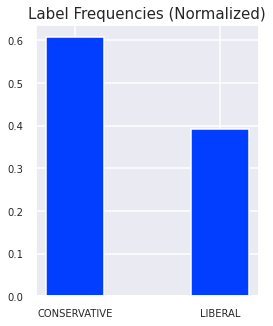

In [159]:
plot_label_frequencies(corpus, 
                          document_col="tokens",
                          label_col="stance",
                          figsize=(4,5),
                          barwidth=0.4,
                          filepath="images/corpus-statistics/stance-frequencies.png")

##### *C.3.1.2 - `issue`*

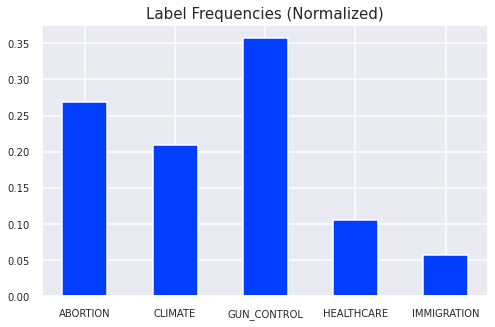

In [160]:
plot_label_frequencies(corpus, 
                          document_col="tokens",
                          label_col="issue",
                          figsize=(8,5),
                          filepath="images/corpus-statistics/issue-frequencies.png")

### *C.3.2 - Average Length of Tokenized Document*

In [161]:
average_token_length(corpus, document_col="tokens")

14.07

> The average length of the normalized Corpus was $14.13\ \text{tokens}/\text{document}$, which implies a couple of sentences worth of tokens, on average, made it through the text normalization process. Since there is only an average of $14$-$15$ tokens per normalized comment, collecting $N$-grams larger than bigrams isn't likely to provide much additional benefit. For this reason, unigrams and bigrams were considered during the vectorization process (see *__Section C.3__*).

### *C.3.3 - Ratio of Corpus Size to Document Size*

In [162]:
corpus.shape[0] / average_token_length(corpus, document_col="tokens")

471.99715707178393

### *C.3.4 - Document Frequencies by Label*

> The following plots list the top $15$ most frequently occurring words for each label in the Corpus. Note that the ***document frequency*** of a certain word refers to the number of documents (i.e. tweets) in the corpus containing that word. 

##### *C.3.3.1 - `stance`*

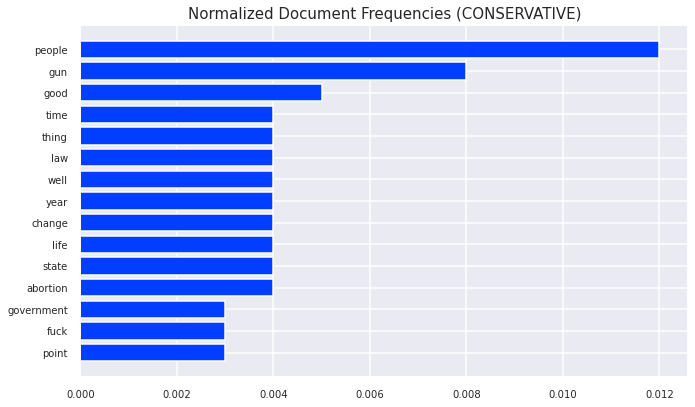

In [163]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="stance",
                              label_name="CONSERVATIVE", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/CONSERVATIVE-document-frequencies.png")

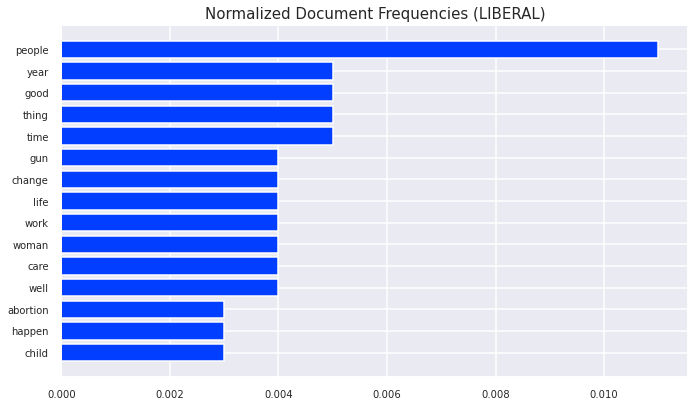

In [164]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="stance",
                              label_name="LIBERAL", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/LIBERAL-document-frequencies.png")

##### *C.3.3.2 - `issue`*

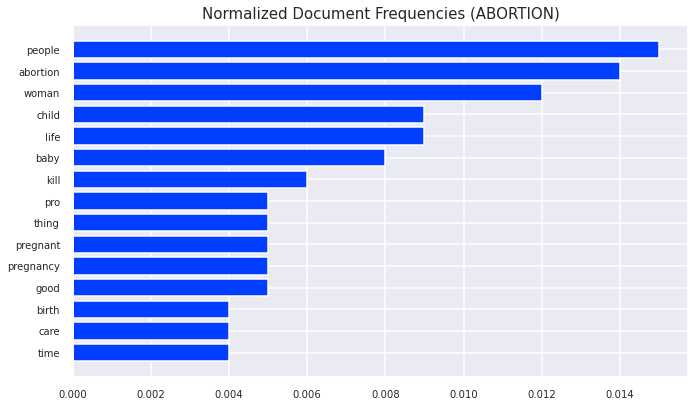

In [165]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="issue",
                              label_name="ABORTION", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/ABORTION-document-frequencies.png")

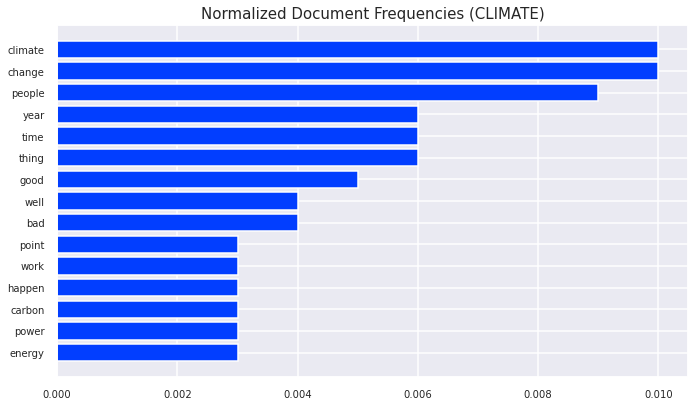

In [166]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="issue",
                              label_name="CLIMATE", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/CLIMATE-document-frequencies.png")

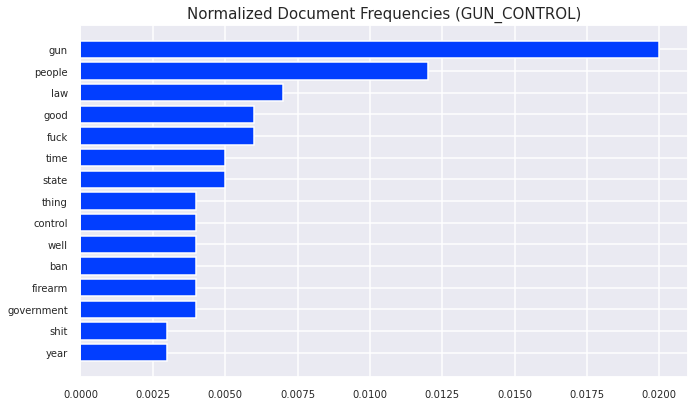

In [167]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="issue",
                              label_name="GUN_CONTROL", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/GUN_CONTROL-document-frequencies.png")

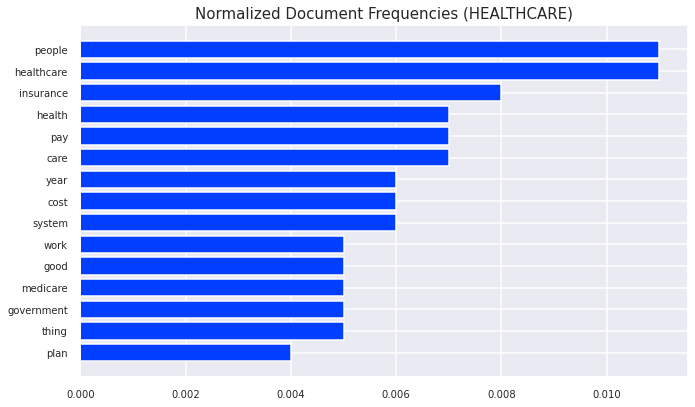

In [168]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="issue",
                              label_name="HEALTHCARE", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/HEALTHCARE-document-frequencies.png")

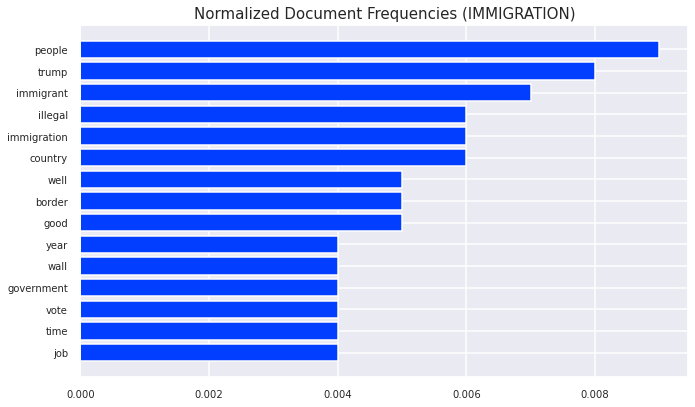

In [169]:
plot_document_frequencies(corpus, 
                              document_col="tokens",
                              label_col="issue",
                              label_name="IMMIGRATION", 
                              N=15, 
                              figsize=(10,6), 
                              filepath="images/corpus-statistics/IMMIGRATION-document-frequencies.png")

The plots above indicate that:

* words such as __`good`__, __`love`__, __`well`__, and __`laugh`__ are more prevalent in tweets with a __`POSITIVE`__ sentiment 
* words such as __`start`__, __`leave`__, __`eat`__, and __`rain`__ are more prevalent in tweets with a __`NEUTRAL`__ sentiment 
* words such as __`bad`__, __`sad`__, __`hate`__, and __`miss`__ are more prevalent in tweets with a __`NEGATIVE`__ sentiment 

> As these words would typically be associated with those sentiments, the plots confirm that the *Training Corpus* was indeed labeled accurately.

## C.4 - Extracting the Trainining, Validation, and Test Sets

> The Corpus was randomly split into a Training, Validation, and Test Set. The Training Set contained $70\%$ of the Corpus samples, while the remaining samples were split evenly between the Validation and Test Sets ($15\%$ each). 

In [170]:
if isinstance(corpus["tokens"][0], list):
    corpus["tokens"] = corpus["tokens"].apply(' '.join)

In [171]:
X = corpus["tokens"]
y = corpus[["issue", "stance"]]

In [172]:
X_train, X_validate_and_test, Y_train, Y_validate_and_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_validate_and_test, Y_validate_and_test, test_size=0.50, random_state=42)

In [173]:
print(f"X_train:\t({' x '.join(map(str, X_train.shape))})")
print(f"Y_train:\t({' x '.join(map(str, Y_train.shape))})\n")
print(f"X_validate:\t({' x '.join(map(str, X_validate.shape))})")
print(f"Y_validate:\t({' x '.join(map(str, Y_validate.shape))})\n")
print(f"X_test:\t\t({' x '.join(map(str, X_test.shape))})")
print(f"Y_test:\t\t({' x '.join(map(str, Y_test.shape))})")

X_train:	(4648)
Y_train:	(4648 x 2)

X_validate:	(996)
Y_validate:	(996 x 2)

X_test:		(997)
Y_test:		(997 x 2)


## C.5 - Vectorizing the Training, Validation, and Test Sets

> The number of features used during the vectorization process was $15,000$. Only unigrams were considered. The Training, Validation, and Test Set were vectorized via the `sklearn.CountVectorizer` transformer and `tensorflow.keras.layers.TextVectorization` layer.  

In [174]:
MAX_FEATURES = 1_000
MAX_DOCUMENT_LENGTH = max(len(token_list) for token_list in corpus.tokens.str.split())

### *C.5.1 - Integer Encoding*

> The `tensorflow.keras.layers.TextVectorization` layer was adapted to the Training Set and then used to transform the Training, Validation, and Test Set into a collection of $1$-dimensional tensors comprised of integer indexed tokens.

In [175]:
integer_encoder = TextVectorization(max_tokens=MAX_FEATURES,
                                        standardize=None,
                                        split="whitespace",
                                        ngrams=2,
                                        output_mode="int",
                                        output_sequence_length=MAX_DOCUMENT_LENGTH,
                                        pad_to_max_tokens=False)

In [176]:
with tf.device("CPU"):
    integer_encoder.adapt(X_train.values)

In [177]:
X_train_IE = integer_encoder(X_train.values)
X_train_IE

<tf.Tensor: shape=(4648, 427), dtype=int64, numpy=
array([[  5, 932,   1, ...,   0,   0,   0],
       [118,   1,   1, ...,   0,   0,   0],
       [ 84,   1,   1, ...,   0,   0,   0],
       ...,
       [  4, 895,   1, ...,   0,   0,   0],
       [625,  50,   1, ...,   0,   0,   0],
       [ 56,   1, 452, ...,   0,   0,   0]])>

In [178]:
X_validate_IE = integer_encoder(X_validate.values)
X_validate_IE

<tf.Tensor: shape=(996, 427), dtype=int64, numpy=
array([[653,  38,  84, ...,   0,   0,   0],
       [ 54, 131, 829, ...,   0,   0,   0],
       [263,   1,  10, ...,   0,   0,   0],
       ...,
       [  1,   0,   0, ...,   0,   0,   0],
       [289, 516, 258, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]])>

In [179]:
X_test_IE = integer_encoder(X_test.values)
X_test_IE

<tf.Tensor: shape=(997, 427), dtype=int64, numpy=
array([[385, 265,   1, ...,   0,   0,   0],
       [  1,  23, 133, ...,   0,   0,   0],
       [  1,   1, 613, ...,   0,   0,   0],
       ...,
       [124,   1,   1, ...,   0,   0,   0],
       [  1,   0,   0, ...,   0,   0,   0],
       [470,   1,  18, ...,   0,   0,   0]])>

In [180]:
print(f"X_train_IE:\t({' x '.join(map(str, X_train_IE.shape))})")
print(f"X_validate_IE:\t({' x '.join(map(str, X_validate_IE.shape))})")
print(f"X_test_IE:\t({' x '.join(map(str, X_test_IE.shape))})")

X_train_IE:	(4648 x 427)
X_validate_IE:	(996 x 427)
X_test_IE:	(997 x 427)


### *C.5.2 - Multi-Hot Encoding with TF-IDF Weighting*

> The `tensorflow.keras.layers.TextVectorization` layer was adapted to the Training Set and then used to transform the Training, Validation, and Test Set into a collection of $1$-dimensional tensors comprised of integer indexed tokens.

In [181]:
tv = TextVectorization(max_tokens=MAX_FEATURES,
                                        standardize=None,
                                        split="whitespace",
                                        ngrams=2,
                                        output_mode="tf-idf",
                                        pad_to_max_tokens=False)

In [182]:
with tf.device("CPU"):
    tv.adapt(X_train.values)

In [183]:
X_train_TV = tv(X_train.values)
X_train_TV

<tf.Tensor: shape=(4648, 1000), dtype=float32, numpy=
array([[ 15.267195 ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [ 25.445326 ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [ 55.979717 ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [ 30.53439  ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [ 40.71252  ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [254.45325  ,   2.0913928,   0.       , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)>

In [184]:
X_validate_TV = tv(X_validate.values)
X_validate_TV

<tf.Tensor: shape=(996, 1000), dtype=float32, numpy=
array([[ 81.42504  ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [290.07672  ,   2.0913928,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [259.54233  ,   4.1827855,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [  5.089065 ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [ 55.979717 ,   0.       ,   0.       , ...,   0.       ,
          0.       ,   0.       ],
       [ 76.335976 ,   2.0913928,   0.       , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)>

In [185]:
X_test_TV = tv(X_test.values)
X_test_TV

<tf.Tensor: shape=(997, 1000), dtype=float32, numpy=
array([[  5.089065,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [188.29541 ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [ 45.801586,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [ 45.801586,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  5.089065,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [ 20.35626 ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)>

In [186]:
print(f"X_train_TV:\t({' x '.join(map(str, X_train_TV.shape))})")
print(f"X_validate_TV:\t({' x '.join(map(str, X_validate_TV.shape))})")
print(f"X_test_TV:\t({' x '.join(map(str, X_test_TV.shape))})")

X_train_TV:	(4648 x 1000)
X_validate_TV:	(996 x 1000)
X_test_TV:	(997 x 1000)


## C.6 - Encoding the Training, Validation, and Test Labels

### *C.6.1 - `stance`*

In [187]:
lb_stance = LabelBinarizer()

In [188]:
y_train_stance = lb_stance.fit_transform(Y_train.stance)
y_train_stance

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [189]:
y_validate_stance = lb_stance.transform(Y_validate.stance)
y_validate_stance

array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
    

In [190]:
y_test_stance = lb_stance.transform(Y_test.stance)
y_test_stance

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
    

In [191]:
print(f"y_train_stance:\t\t({' x '.join(map(str, y_train_stance.shape))})")
print(f"y_validate_stance:\t({' x '.join(map(str, y_validate_stance.shape))})")
print(f"y_test_stance:\t\t({' x '.join(map(str, y_test_stance.shape))})")

y_train_stance:		(4648 x 1)
y_validate_stance:	(996 x 1)
y_test_stance:		(997 x 1)


### *C.6.2 - `issue`*

In [192]:
lb_issue = LabelBinarizer()

In [193]:
y_train_issue = lb_issue.fit_transform(Y_train.issue)
y_train_issue

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

In [194]:
y_validate_issue = lb_issue.transform(Y_validate.issue)
y_validate_issue

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0]])

In [195]:
y_test_issue = lb_issue.transform(Y_test.issue)
y_test_issue

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [196]:
print(f"y_train_issue:\t\t({' x '.join(map(str, y_train_issue.shape))})")
print(f"y_validate_issue:\t({' x '.join(map(str, y_validate_issue.shape))})")
print(f"y_test_issue:\t\t({' x '.join(map(str, y_test_issue.shape))})")

y_train_issue:		(4648 x 5)
y_validate_issue:	(996 x 5)
y_test_issue:		(997 x 5)


## C.7 - Balancing the Training Labels

In [197]:
issue_weights = compute_sample_weight("balanced", Y_train["issue"])
issue_weights


array([0.74606742, 0.74606742, 0.56033755, ..., 1.90491803, 3.28480565,
       0.9563786 ])

In [198]:
stance_weights = compute_sample_weight("balanced", Y_train["stance"])
stance_weights

array([1.27342466, 0.82323769, 0.82323769, ..., 0.82323769, 1.27342466,
       1.27342466])

## C.8 - Saving the Preprocessed Data

In [199]:
np.save("data/train/X_train_IE.npy", X_train_IE)
np.save("data/train/X_train_TV.npy", X_train_TV)
np.save("data/train/y_train_issue.npy", y_train_issue)
np.save("data/train/y_train_stance.npy", y_train_stance)
np.save("data/train/issue_weights.npy", issue_weights)
np.save("data/train/stance_weights.npy", stance_weights)

In [200]:
np.save("data/validate/X_validate_IE.npy", X_validate_IE)
np.save("data/validate/X_validate_TV.npy", X_validate_TV)
np.save("data/validate/y_validate_issue.npy", y_validate_issue)
np.save("data/validate/y_validate_stance.npy", y_validate_stance)

In [201]:
np.save("data/test/X_test_IE.npy", X_test_IE)
np.save("data/test/X_test_TV.npy", X_test_TV)
np.save("data/test/y_test_issue.npy", y_test_issue)
np.save("data/test/y_test_stance.npy", y_test_stance)

# D. *Modeling*

In [202]:
X_train_IE = np.load("data/train/X_train_IE.npy")
X_train_TV = np.load("data/train/X_train_TV.npy")

y_train_issue = np.load("data/train/y_train_issue.npy")
y_train_stance = np.load("data/train/y_train_stance.npy")

issue_weights = np.load("data/train/issue_weights.npy")
stance_weights = np.load("data/train/stance_weights.npy")

In [203]:
X_validate_IE = np.load("data/validate/X_validate_IE.npy")
X_validate_TV = np.load("data/validate/X_validate_TV.npy")

y_validate_issue = np.load("data/validate/y_validate_issue.npy")
y_validate_stance = np.load("data/validate/y_validate_stance.npy")

In [204]:
X_test_IE = np.load("data/test/X_test_IE.npy")
X_test_TV = np.load("data/test/X_test_TV.npy")

y_test_issue = np.load("data/test/y_test_issue.npy")
y_test_stance = np.load("data/test/y_test_stance.npy")

Since over-representing sentiment (high false positive rate) and under-representing sentiment (high false negative rate) are both equally undesirable, the $F_1\text{-Score}$ was the primary metric by which the models were evaluated. This score takes into account both recall ($R$) and precision ($P$) - if one of these metrics suffers, it will be reflected in the $F_1\text{-Score}$.

The formula for the $F_1\text{-Score}$ is:
> $$ F_1 = 2(\dfrac{1}{R} + \dfrac{1}{P})$$



In [205]:
y_train_issue_true = lb_issue.inverse_transform(y_train_issue)
y_validate_issue_true = lb_issue.inverse_transform(y_validate_issue)

In [206]:
y_train_stance_true = lb_stance.inverse_transform(y_train_stance)
y_validate_stance_true = lb_stance.inverse_transform(y_validate_stance)

## D.1 - *Dense Neural Network*

In [207]:
VOCABULARY_SIZE = 1_000
NUM_ISSUES = 5

### *D.1.1 - Building and Evaluating Various Architectures*

> A series of $5$ Dense Neural Networks (`DNN 1`, `DNN 2`, `DNN 3`, `DNN 4`, and `DNN 5`), containing one or more hidden layers, were trained on the Training Set. The main parameters being altered wer: the architecture and the number/strength of dropout layers. These models were validated against the Validation Set after every training epoch. After each of the $5$ training processes had been completed, the epoch in which the lowest cross-entropy loss on the Validation Set ocurred was determined and the model parameters chosen accordingly.The model with the highest $F_1\text{-Score}$ on the Validation Set was chosen as the best model.

In [208]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

##### *`DNN 1`*

In [209]:
MODEL_NAME = "dnn_1"

comment = Input(shape=(VOCABULARY_SIZE,), name="comment") 

x = Dense(64, activation="relu")(comment)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(8, activation="relu")(x)

stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

dnn = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

dnn.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = dnn.fit(X_train_TV, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=64,
                       epochs=100,        
                       validation_data=(X_validate_TV, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

Epoch 1/100
71/73 [============================>.] - ETA: 0s - loss: 2.4011 - issue_loss: 1.6665 - stance_loss: 0.7346 - issue_accuracy: 0.2095 - stance_accuracy: 0.5383

In [ ]:
loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5")

y_train_dnn1_pred = loaded_model.predict(X_train_TV)
y_validate_dnn1_pred = loaded_model.predict(X_validate_TV)

y_train_issue_pred = lb_issue.inverse_transform(y_train_dnn1_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_dnn1_pred[0])


y_train_stance_pred = lb_stance.inverse_transform(y_train_dnn1_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_dnn1_pred[1])

plot_validation_confusion_matrices(y_train_issue_true, 
                            y_train_issue_pred, 
                            y_validate_issue_true, 
                            y_validate_issue_pred, 
                            target_names=lb_issue.classes_, 
                            normalize="true", 
                            sample_weight=issue_weights,
                            figsize=(18,7),
                            filepath="images/dnn1/validation-confusion-matrices.png")
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(10,4),
                            filepath="images/dnn1/validation-confusion-matrices.png")

##### *`DNN 2`*

In [ ]:
MODEL_NAME = "dnn_2"

comment = Input(shape=(VOCABULARY_SIZE,), name="comment") 

x = Dense(64, activation="relu")(comment)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(16, activation="relu")(x)
x = Dense(8, activation="relu")(x)

stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

dnn = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

dnn.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = dnn.fit(X_train_TV, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=64,
                       epochs=100,        
                       validation_data=(X_validate_TV, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

In [ ]:
loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5")

y_train_dnn1_pred = loaded_model.predict(X_train_TV)
y_validate_dnn1_pred = loaded_model.predict(X_validate_TV)

y_train_issue_pred = lb_issue.inverse_transform(y_train_dnn1_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_dnn1_pred[0])


y_train_stance_pred = lb_stance.inverse_transform(y_train_dnn1_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_dnn1_pred[1])

plot_validation_confusion_matrices(y_train_issue_true, 
                            y_train_issue_pred, 
                            y_validate_issue_true, 
                            y_validate_issue_pred, 
                            target_names=lb_issue.classes_, 
                            normalize="true", 
                            sample_weight=issue_weights,
                            figsize=(18,7),
                            filepath="images/dnn1/validation-confusion-matrices.png")
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(10,4),
                            filepath="images/dnn1/validation-confusion-matrices.png")

##### *`DNN 3`*

In [ ]:
MODEL_NAME = "dnn_3"

comment = Input(shape=(VOCABULARY_SIZE,), name="comment") 

x = Dense(64, activation="relu")(comment)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(8, activation="relu")(x)
x = Dropout(0.1)(x)

stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

dnn = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

dnn.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = dnn.fit(X_train_TV, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=64,
                       epochs=100,        
                       validation_data=(X_validate_TV, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

In [ ]:
loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5")

y_train_dnn1_pred = loaded_model.predict(X_train_TV)
y_validate_dnn1_pred = loaded_model.predict(X_validate_TV)

y_train_issue_pred = lb_issue.inverse_transform(y_train_dnn1_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_dnn1_pred[0])


y_train_stance_pred = lb_stance.inverse_transform(y_train_dnn1_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_dnn1_pred[1])

plot_validation_confusion_matrices(y_train_issue_true, 
                            y_train_issue_pred, 
                            y_validate_issue_true, 
                            y_validate_issue_pred, 
                            target_names=lb_issue.classes_, 
                            normalize="true", 
                            sample_weight=issue_weights,
                            figsize=(18,7),
                            filepath="images/dnn1/validation-confusion-matrices.png")
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(10,4),
                            filepath="images/dnn1/validation-confusion-matrices.png")

##### *`DNN 4`*

In [ ]:
MODEL_NAME = "dnn_4"

comment = Input(shape=(VOCABULARY_SIZE,), name="comment") 

x = Dense(128, activation="relu")(comment)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(8, activation="relu")(x)

stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

dnn = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

dnn.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = dnn.fit(X_train_TV, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=64,
                       epochs=100,        
                       validation_data=(X_validate_TV, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

In [ ]:
loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5")

y_train_dnn1_pred = loaded_model.predict(X_train_TV)
y_validate_dnn1_pred = loaded_model.predict(X_validate_TV)

y_train_issue_pred = lb_issue.inverse_transform(y_train_dnn1_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_dnn1_pred[0])


y_train_stance_pred = lb_stance.inverse_transform(y_train_dnn1_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_dnn1_pred[1])

plot_validation_confusion_matrices(y_train_issue_true, 
                            y_train_issue_pred, 
                            y_validate_issue_true, 
                            y_validate_issue_pred, 
                            target_names=lb_issue.classes_, 
                            normalize="true", 
                            sample_weight=issue_weights,
                            figsize=(18,7),
                            filepath="images/dnn1/validation-confusion-matrices.png")
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(10,4),
                            filepath="images/dnn1/validation-confusion-matrices.png")

##### *`DNN 5`*

In [ ]:
MODEL_NAME = "dnn_5"

comment = Input(shape=(VOCABULARY_SIZE,), name="comment") 

x = Dense(128, activation="relu")(comment)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(8, activation="relu")(x)

stance = Dense(1, activation="sigmoid", name="stance")(x)
issue = Dense(NUM_ISSUES, activation="softmax", name="issue")(x)

dnn = Model(inputs=comment, outputs=[issue, stance], name=MODEL_NAME)

dnn.compile(optimizer="Adam", 
                loss={"issue": "categorical_crossentropy", "stance": "binary_crossentropy"},
                metrics="accuracy")

checkpoint = ModelCheckpoint(filepath=f"models/{''.join(MODEL_NAME.split('_'))}.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min")
with tf.device("GPU"):
    history = dnn.fit(X_train_TV, 
                       {"issue": y_train_issue, "stance": y_train_stance}, 
                       batch_size=64,
                       epochs=100,        
                       validation_data=(X_validate_TV, {"issue": y_validate_issue, "stance": y_validate_stance}),
                       validation_batch_size=32,
                       sample_weight={"issue": issue_weights, "stance": stance_weights}, 
                       callbacks=[early_stopping, checkpoint],
                       verbose=1)

plot_history(MODEL_NAME, 
              history.history, 
              filepath=f"images/{''.join(MODEL_NAME.split('_'))}/history.png",
              figsize=(14,12))

In [ ]:
loaded_model = load_model(f"models/{''.join(MODEL_NAME.split('_'))}.h5")

y_train_dnn1_pred = loaded_model.predict(X_train_TV)
y_validate_dnn1_pred = loaded_model.predict(X_validate_TV)

y_train_issue_pred = lb_issue.inverse_transform(y_train_dnn1_pred[0])
y_validate_issue_pred = lb_issue.inverse_transform(y_validate_dnn1_pred[0])


y_train_stance_pred = lb_stance.inverse_transform(y_train_dnn1_pred[1])
y_validate_stance_pred = lb_stance.inverse_transform(y_validate_dnn1_pred[1])

plot_validation_confusion_matrices(y_train_issue_true, 
                            y_train_issue_pred, 
                            y_validate_issue_true, 
                            y_validate_issue_pred, 
                            target_names=lb_issue.classes_, 
                            normalize="true", 
                            sample_weight=issue_weights,
                            figsize=(18,7),
                            filepath="images/dnn1/validation-confusion-matrices.png")
plot_validation_confusion_matrices(y_train_stance_true, 
                            y_train_stance_pred, 
                            y_validate_stance_true, 
                            y_validate_stance_pred, 
                            target_names=lb_stance.classes_, 
                            normalize="true", 
                            sample_weight=stance_weights,
                            figsize=(10,4),
                            filepath="images/dnn1/validation-confusion-matrices.png")